## Custom camera projection

User defined ray distribution: ray origins and directions in camera textures.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX
from plotoptix.materials import m_flat
from plotoptix.geometry import PinnedBuffer

Create the raytracer:

In [2]:
width = 1000
height = 1000

def update_image(rt: NpOptiX) -> None:
    img.set_data(rt._img_rgba)
    plt.draw()

rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

Setup for the usual image making - camera, lights and ambient, postprocessing. This setup is needed only to show how the scene looks like, it is not needed for calculation and displaying the hit and distance information.

In [3]:
rt.set_param(min_accumulation_step=4, max_accumulation_frames=100)

rt.set_float("tonemap_exposure", 1.0)
rt.set_float("tonemap_gamma", 2.2)
rt.add_postproc("Gamma")

rt.setup_light("light1", pos=[-15, 10, 30], color=2, radius=8)
rt.setup_light("light2", pos=[-15, -10, 30], color=2, radius=8)
rt.set_ambient([0.03, 0.04, 0.05])
rt.set_background(0)

rt.setup_camera("cam1", eye=[20, 25, 60], fov=25)

Create and upload two surfaces. Use the default, *diffuse* material for the moment.

In [4]:
# a smooth surface that will be used as a source o rays later:

rxz = (-10, 10)
n = 500

xz = np.linspace(rxz[0], rxz[1], n)
X, Z = np.meshgrid(xz, xz)

Y1 = np.sin(np.sqrt(X**2 + Z**2)) - 1

rt.set_data_2d("surface1", Y1, c=[0.9, 0.8, 0.7],
                range_x=rxz, range_z=rxz,
                make_normals=True)

# second surface, placed above the first one (a more coarse, for fun)

rxz2 = (-15, 15)
n2 = 20

xz2 = np.linspace(rxz2[0], rxz2[1], n2)
X2, Z2 = np.meshgrid(xz2, xz2)

Y2 = np.sin(np.sqrt((1.5*X2+0.3)**2 + (Z2+0.3)**2)) + 2

rt.set_data_2d("surface2", Y2, c=[0.7, 0.8, 0.9],
                range_x=rxz2, range_z=rxz2,
                make_normals=False)

Show the output image here:

<IPython.core.display.Javascript object>


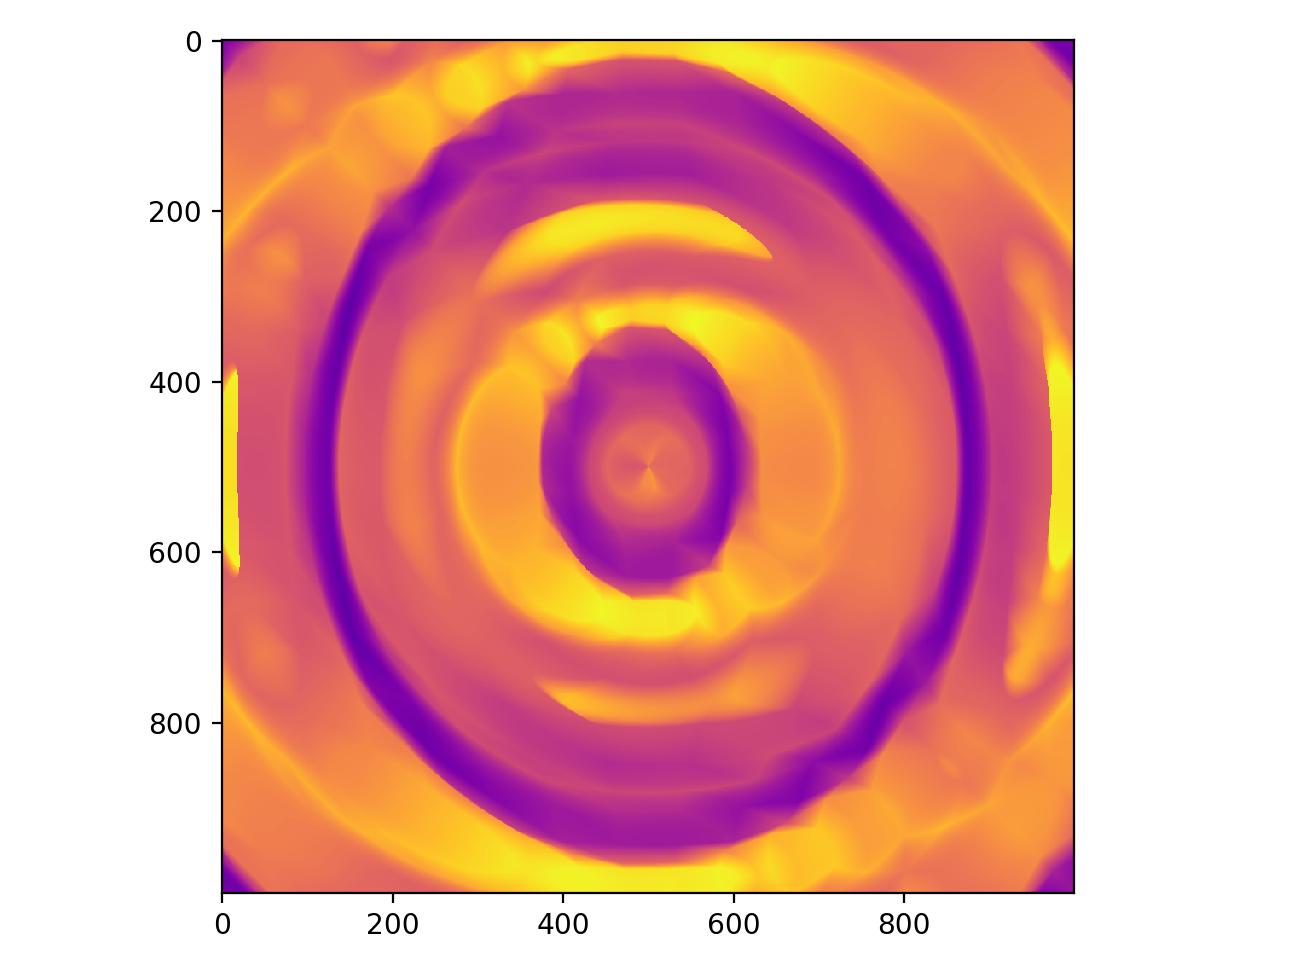

In [5]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width)), cmap=plt.get_cmap("plasma"))
plt.tight_layout()

Start the ray tracing:

In [6]:
rt.start()

Have a look from another angle to see the other surface better:

In [7]:
rt.update_camera("cam1", eye=[20, -15, 60], fov=25)

Now, change the configuration to the **custom projection** camera.

- prepare textures with ray origins and directions
- use flat shading material for performance
- display hit info instead rgb data

In [8]:
# use mesh data of the `surface1` geometry to create textures

with PinnedBuffer(rt.geometry_data["surface1"], "Positions") as P:
    eye = np.zeros((n,n,4), dtype=np.float32)
    eye[:,:,:3] = P.reshape(n,n,3)
    rt.set_texture_2d("eye", eye)

with PinnedBuffer(rt.geometry_data["surface1"], "Vectors") as N:
    rdir = np.zeros((n,n,4), dtype=np.float32)
    rdir[:,:,:3] = N.reshape(n,n,3)
    rt.set_texture_2d("dir", rdir)
    
rt.setup_camera("cam2", cam_type="CustomProjXYZtoDir", textures=["eye", "dir"])

Display distance from the ray origin to the first hit:

In [9]:
# NOTE: no need for multiple passes if only the distance is calculated, so set up just 1 pass:
rt.set_param(min_accumulation_step=1, max_accumulation_frames=1)

# flat shading material - no secondary rays are traced
rt.setup_material("flat", m_flat)
rt.update_data_2d("surface1", mat="flat")
rt.update_data_2d("surface2", mat="flat")

# and the new callback function
def update_image(rt: NpOptiX) -> None:
    dist = rt._hit_pos[:,:,3].reshape(rt._height, rt._width)   # hit distance from the ray origin
    fid = rt._geo_id[:,:,1].reshape(rt._height, rt._width)     # face id data, or empty region signature
    dmax = np.amax(dist[fid < 0xFFFFFFFF])
    dmin = np.amin(dist[fid < 0xFFFFFFFF])
    img.set_data(dist)                                         # update figure using distance data
    img.set_clim(vmin=dmin, vmax=dmax)
    plt.draw()
    
rt.set_launch_finished_cb(update_image)

Close the ray-tracer.

In [9]:
rt.close()